## UBP x Paymaya project

### Aim: 


#### Background: 


*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import bokeh
import collections
import community
import powerlaw 
import operator 

from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx
from bokeh.models import GraphRenderer, StaticLayoutProvider, LinearColorMapper, ColumnDataSource
from bokeh.models import Circle, HoverTool, MultiLine, Plot, Range1d, BoxZoomTool, ResetTool, WheelZoomTool, TapTool
from bokeh.palettes import Spectral8, Spectral4
from bokeh.transform import linear_cmap 

In [2]:
print(nx.__version__)
print(bokeh.__version__)

2.6.3
2.3.2


In [3]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

*import data*

#### import own level 2 dataset

In [4]:
lvl2_df = pd.read_csv('.\data\level_2.csv')

In [5]:
lvl2_df.tail(10)

,Unnamed: 0,tran_date_x,source_name_x,target_name_x,TargetBank_x,txn_amount_x,response_x,tran_date_y,source_name_y,target_name_y,TargetBank_y,txn_amount_y,response_y,day_diff
207992,21555532,2021-03-12,ma theresa natalio mariano,baby zelle mariano,UBP,5700.0,0,2021-03-13,baby zelle mariano,jessa l potesas,NonUBP,3000.0,0,1
207993,21555533,2021-02-23,james emil dado,ian wilson joseph ponce,UBP,1700.0,0,2021-02-24,ian wilson joseph ponce,alphared management system inc,NonUBP,50000.0,1,1
207994,21555534,2021-02-23,james emil dado,ian wilson joseph ponce,UBP,1700.0,0,2021-02-24,ian wilson joseph ponce,randy s quiogue,NonUBP,12000.0,1,1
207995,21555535,2021-02-23,james emil dado,ian wilson joseph ponce,UBP,1700.0,0,2021-02-24,ian wilson joseph ponce,alphared management system inc,NonUBP,50000.0,1,1
207996,21556116,2021-03-03,jeaneaiko alison calderon,madeleine denise verano,UBP,100000.0,0,2021-03-04,madeleine denise verano,jhona,NonUBP,3900.0,1,1
207997,21556117,2021-03-03,jeaneaiko alison calderon,madeleine denise verano,UBP,100000.0,0,2021-03-04,madeleine denise verano,stevien,NonUBP,3900.0,1,1
207998,21556118,2021-03-03,jeaneaiko alison calderon,madeleine denise verano,UBP,100000.0,0,2021-03-04,madeleine denise verano,shayne,NonUBP,50000.0,1,1
207999,21556119,2021-03-03,jeaneaiko alison calderon,madeleine denise verano,UBP,100000.0,0,2021-03-04,madeleine denise verano,shayne,NonUBP,30000.0,1,1
208000,21556120,2021-03-03,jeaneaiko alison calderon,madeleine denise verano,UBP,100000.0,0,2021-03-04,madeleine denise verano,jaaron,NonUBP,14000.0,1,1
208001,21556216,2020-10-26,ryan beluso,regie ibarreta,UBP,18000.0,1,2020-10-27,regie ibarreta,mila arandia,NonUBP,29000.0,1,1


levels 
<br> Level1 (one edge):
UBP to OtherUBP/ UBP to paymaya

Level 2 (two edges):
UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

Level 3 (three edges or more):
UBP to UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

In [6]:
lvl2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208002 entries, 0 to 208001
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     208002 non-null  int64  
 1   tran_date_x    208002 non-null  object 
 2   source_name_x  208002 non-null  object 
 3   target_name_x  208002 non-null  object 
 4   TargetBank_x   208002 non-null  object 
 5   txn_amount_x   208002 non-null  float64
 6   response_x     208002 non-null  int64  
 7   tran_date_y    208002 non-null  object 
 8   source_name_y  208002 non-null  object 
 9   target_name_y  208002 non-null  object 
 10  TargetBank_y   208002 non-null  object 
 11  txn_amount_y   208002 non-null  float64
 12  response_y     208002 non-null  int64  
 13  day_diff       208002 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 22.2+ MB


In [7]:
# END transactions are fraud (after series of transfers)
lvl2_df['response_y'].value_counts(normalize=True)

1    0.961294
0    0.038706
Name: response_y, dtype: float64

<span style='color:red'>
UBP -> UBP -> non-UBP
<br> source_name_x -> target_name_x/ source_name_y -> target_name_y</span>

#### level 2: UBP to UBP to other nonUBP

In [8]:
tmp1 = lvl2_df[['tran_date_x','source_name_x','target_name_x','TargetBank_x','txn_amount_x','response_x']].rename(
    columns={'tran_date_x': 'tran_date',
            'source_name_x': 'source_name',
            'target_name_x': 'target_name',
            'TargetBank_x': 'TargetBank',
            'txn_amount_x': 'txn_amount',
            'response_x': 'response'}).drop_duplicates(subset=['tran_date','source_name','target_name'])

In [9]:
tmp1 = tmp1[(tmp1['source_name']!=tmp1['target_name'])]

In [10]:
tmp1.shape

(2963, 6)

In [11]:
tmp2 = lvl2_df[['tran_date_y','source_name_y','target_name_y','TargetBank_y','txn_amount_y','response_y']].rename(
    columns={'tran_date_y': 'tran_date',
            'source_name_y': 'source_name',
            'target_name_y': 'target_name',
            'TargetBank_y': 'TargetBank',
            'txn_amount_y': 'txn_amount',
            'response_y': 'response'}).drop_duplicates(subset=['tran_date','source_name','target_name'])

In [12]:
tmp2 = tmp2[(tmp2['source_name']!=tmp2['target_name'])]

In [13]:
tmp2.shape

(29770, 6)

In [14]:
tmp2['TargetBank'].value_counts()

NonUBP     15902
Gcash      13501
paymaya      367
Name: TargetBank, dtype: int64

In [15]:
# focus on txn to 'NonUBP'
tmp2 = tmp2[(tmp2['TargetBank']=='NonUBP')]
tmp2

,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,2021-03-30,digipay,irvin,NonUBP,35000.0,1
21,2021-03-06,jennifer iracta,darius bautista,NonUBP,11000.0,1
91,2021-02-23,jennifer iracta,odelon mallari,NonUBP,2000.0,1
96,2021-02-23,jennifer iracta,justin roldan v,NonUBP,1000.0,1
98,2021-02-23,jennifer iracta,rodel malijoc,NonUBP,10000.0,1
...,...,...,...,...,...,...
207996,2021-03-04,madeleine denise verano,jhona,NonUBP,3900.0,1
207997,2021-03-04,madeleine denise verano,stevien,NonUBP,3900.0,1
207998,2021-03-04,madeleine denise verano,shayne,NonUBP,50000.0,1
208000,2021-03-04,madeleine denise verano,jaaron,NonUBP,14000.0,1


In [16]:
tmp2.shape

(15902, 6)

In [17]:
lvl2_final = pd.concat([tmp1,tmp2],axis=0)

In [18]:
lvl2_final.head()

,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,2021-03-29,personal savings,digipay,UBP,30000.0,1
12,2021-03-05,john ildefonso villanueva,jennifer iracta,UBP,73220.0,1
89,2021-02-22,jennelyn de guzman,jennifer iracta,UBP,3500.0,1
1573,2021-03-05,gizelle reyes,jennifer iracta,UBP,146000.0,1
1661,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1


In [19]:
lvl2_final.shape

(18865, 6)

##### percentage of frauds in level2

In [20]:
lvl2_final[['response']].value_counts(normalize=True)

response
1           0.938298
0           0.061702
dtype: float64

In [21]:
lvl2_final[lvl2_final['TargetBank']!='UBP'][['response']].value_counts(normalize=True)

response
1           0.9429
0           0.0571
dtype: float64

##### Build graph

**define nodes/edges**

In [22]:
# define edges 
df_edges = lvl2_final[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl2_final[['source_name','response']]
df_target = lvl2_final[['target_name','response']]

# node colours 
node_colours = {1 : 'red', 0 : 'green'}
df_source['node_colour'] = lvl2_final['response'].map(node_colours)
df_target['node_colour'] = lvl2_final['response'].map(node_colours)

**directed graph**

In [28]:
# create network 
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


##### Network statistics

In [29]:
N = G.order() #G.order(), gives number of nodes 
L = G.size() #G.size(), gives number of edges

avg_deg = float(L) / N #calculate average degree

print("Nodes: ", N)
print("Edges: ", L)
print("Average degree: ", avg_deg)

Nodes:  11920
Edges:  13460
Average degree:  1.1291946308724832


##### in-degree/out-degree

In [30]:
# In-degree and Out-degree
in_degrees = G.in_degree()  # dictionary node:degree
out_degrees = G.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees['personal savings']) #txn out of personal savings

Transactions in personal savings: 3
Transactions out personal savings: 445


##### Path Lengths
<br> path length - max number of transactions from one account to the other 
<br> Network diameter is the longest shortest path between any two nodes in the network.

In [31]:
if not 'avg_path_length' in globals(): 
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G, n) 
        total += sum(path_length.values()) #total of all shortest paths from n
    
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path 
            max_path_length = max(path_length.values())         
    avg_path_length = total / (N*(N - 1)) #calculate average.
    
print("Average path length %f" % (avg_path_length)) 
print("Network Diameter or max path length %d" % (max_path_length)) 

Average path length 0.014389
Network Diameter or max path length 14


##### Centrality
**Which account has the highest centrality?**
<br> Betweenness centrality - which account lies on most txn routes
<br> Closeness centrality - which account has the shortest number of transfers to all other account 
<br> Degree centrality - the (general) number of accounts it is connected to
<br> Eigenvector centrality - which account is connected to other important networks
<br> Pagerank - ranks the nodes in the graph based on the structure of the incoming links

**betweenness centrality**

Betweenness mean: 0.000001
1: ('randy villamar', 0.0012969671078111732)
2: ('christian angelo delos santos', 0.000689675897193439)
3: ('ian vincent dedase', 0.0005679602228458372)
4: ('ricardo lasco', 0.0005415181942145474)
5: ('rennelyn mercado', 0.0004123727193278684)
6: ('joseph brutas', 0.00041179762261593053)
7: ('mark nester mendoza', 0.0004020001945101079)
8: ('vincent', 0.000389509796560206)
9: ('aeron paul alfaro', 0.0003754380544557246)
10: ('gerardo cerda jr', 0.00034930737763603896)


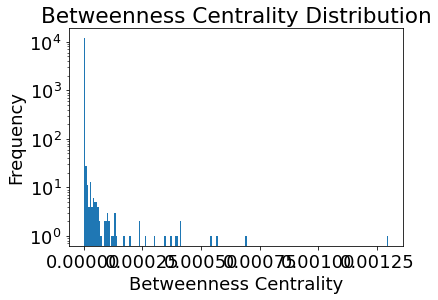

In [32]:
if not 'bet_cen' in globals(): #only calculate this if its not been calculated before
    bet_cen = nx.betweenness_centrality(G)

#Histogram of betweenness
print("Betweenness mean: %f" % (np.array(list(bet_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by betweenness
    print(str(x+1)+ ": " + str(acct_sorted_by_betweenness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(bet_cen.values(), bins=200, density=False) 
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Betweenness Centrality Distribution')
plt.show()


**closeness centrality**

Closeness mean: 0.000859
1: ('alphared management system inc', 0.01842519375218406)
2: ('number', 0.006938822789565301)
3: ('mark', 0.005416956614007294)
4: ('mary jessa dosdos', 0.00535106219857602)
5: ('jessie l dosdos', 0.00535106219857602)
6: ('julie', 0.004331939567652973)
7: ('james', 0.004115536417171177)
8: ('daisy', 0.004080895923413563)
9: ('alvin', 0.004040550147826897)
10: ('jeffrey', 0.00395513512923745)


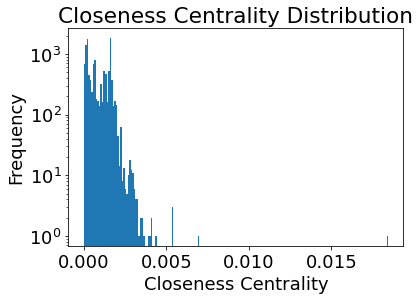

In [33]:
if not 'clo_cen' in globals(): 
    clo_cen = nx.closeness_centrality(G)

#Histogram of closeness
print("Closeness mean: %f" % (np.array(list(clo_cen.values())).mean()))

#get a list of acct sorted by closeness
acct_sorted_by_closeness = sorted(clo_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by closeness
    print(str(x+1)+ ": " + str(acct_sorted_by_closeness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(clo_cen.values(), bins=200, density=False) 
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Closeness Centrality Distribution')
plt.show()


**degree centrality**

Degree mean: 0.000189
1: ('randy villamar', 0.16855440892692342)
2: ('bob marley', 0.043040523533853514)
3: ('personal savings', 0.03758704589311184)
4: ('gerardo cerda jr', 0.0307911737561876)
5: ('kimberly terrora', 0.021897810218978103)
6: ('jay smith', 0.02114271331487541)
7: ('mark lucio', 0.02114271331487541)
8: ('jahn steve evangelista', 0.02055541572279554)
9: ('rei ann del rosario', 0.017535028106384767)
10: ('ivan carl roces', 0.01669603154627066)


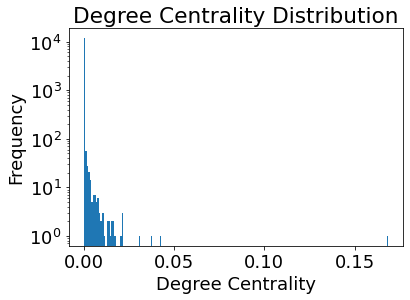

In [34]:
if not 'deg_cen' in globals(): 
    deg_cen = nx.degree_centrality(G)
    
#Histogram of degrees
print("Degree mean: %f" % (np.array(list(deg_cen.values())).mean()))

#get a list of acct sorted by degree
acct_sorted_by_degree = sorted(deg_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by degree
    print(str(x+1)+ ": " + str(acct_sorted_by_degree[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(deg_cen.values(), bins=200, density=False) 
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Degree Centrality Distribution')
plt.show()


**eigenvector centrality**

Eigenvector mean: 0.002451
1: ('gerardo cerda jr', 0.1844404997846684)
2: ('alphared management system inc', 0.17553118227414)
3: ('jellie ann santos', 0.13628351657969182)
4: ('ana daniella talam', 0.12364309779908195)
5: ('mayriel c sobrino', 0.11342027979251948)
6: ('marlo manzano', 0.10818531548990243)
7: ('gcls livestock farm', 0.10701464347696846)
8: ('joseph alino', 0.09919332322628235)
9: ('rei ann del rosario', 0.0946166836232515)
10: ('lorraine vicente', 0.09317384748201034)


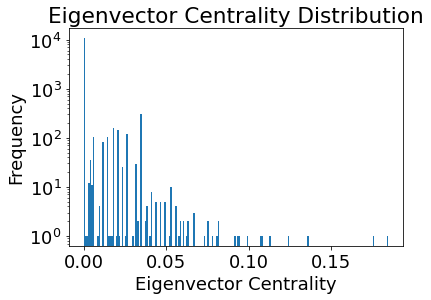

In [35]:
if not 'eig_cen' in globals(): 
    eig_cen = nx.eigenvector_centrality(G, max_iter=200)

#Histogram of eigenvector_centrality
print("Eigenvector mean: %f" % (np.array(list(eig_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_eigenvector = sorted(eig_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by eigenvector
    print(str(x+1)+ ": " + str(acct_sorted_by_eigenvector[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(eig_cen.values(), bins=200, density=False) 
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Eigenvector Centrality Distribution')
plt.show()


**pagerank**

Pagerank mean: 0.000084
1: ('alphared management system inc', 0.002209891771342829)
2: ('christian angelo delos santos', 0.0010843799743075944)
3: ('aeron paul alfaro', 0.0006367757553089831)
4: ('ricardo lasco', 0.0005870369760495172)
5: ('ivan carl roces', 0.000561609288055021)
6: ('mark nester mendoza', 0.0005021790178648406)
7: ('joan gatdula', 0.0004864190383488769)
8: ('claudine abu', 0.0004825146825364212)
9: ('pablo escobar', 0.00047116842451794814)
10: ('annadel vitan', 0.00047002951387503265)


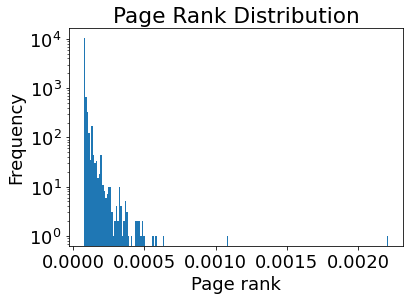

In [36]:
if not 'pagerank_cen' in globals(): 
    pagerank_cen = nx.pagerank(G, max_iter=200)

#Histogram of pagerank
print("Pagerank mean: %f" % (np.array(list(pagerank_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_pagerank = sorted(pagerank_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by pagerank
    print(str(x+1)+ ": " + str(acct_sorted_by_pagerank[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(pagerank_cen.values(), bins=200, density=False) 
plt.xlabel('Page rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Page Rank Distribution')
plt.show()

##### Correlation of centrality measures to fraud

In [37]:
# directed graph
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


In [38]:
nodes_info_dict = {
    'betweenness_centrality': nx.betweenness_centrality,
    'closeness_centrality': nx.closeness_centrality,
    'eigenvector_centrality': nx.eigenvector_centrality_numpy, # otherwise, cannot converge without _numpy
    'pagerank': nx.pagerank 
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G)), orient='index').rename(columns = {0 : 'degree'}).reset_index()

In [39]:
G.order() # number of nodes, should match below

11920

In [40]:
nodes_info # should match G.order()

,index,degree
0,personal savings,448
1,digipay,4
2,john ildefonso villanueva,43
3,jennifer iracta,30
4,jennelyn de guzman,2
...,...,...
11915,randy s quiogue,1
11916,stevien,1
11917,shayne,1
11918,jaaron,1


In [41]:
# computing graph features for each node
for info, fun in nodes_info_dict.items():
    temp = pd.DataFrame.from_dict(fun(G), orient='index').rename(columns = {0 : info}).reset_index()
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'name'})

nodes_info

,name,degree,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,personal savings,448,0.000237,0.000268,3.034406e-19,0.000243
1,digipay,4,0.000006,0.000210,-1.062071e-18,0.000076
2,john ildefonso villanueva,43,0.000014,0.000980,1.491334e-17,0.000300
3,jennifer iracta,30,0.000008,0.001056,1.844782e-17,0.000119
4,jennelyn de guzman,2,0.000000,0.000000,-4.714854e-20,0.000075
...,...,...,...,...,...,...
11915,randy s quiogue,1,0.000000,0.000112,-7.932654e-19,0.000135
11916,stevien,1,0.000000,0.000112,2.799489e-18,0.000105
11917,shayne,1,0.000000,0.000112,4.007714e-18,0.000105
11918,jaaron,1,0.000000,0.000112,3.472505e-18,0.000105


In [42]:
# adding graph features to df
# merge on source_name
lvl2_cen = lvl2_final[['source_name','target_name','tran_date','TargetBank', 'txn_amount','response']].merge(nodes_info, left_on = 'source_name',  
                           right_on='name', how='left').drop('name', axis=1)
lvl2_cen.rename(columns = {k:'source_'+k for k in columns_with_node_infos}, inplace = True)

# merge on target_name
lvl2_cen = lvl2_cen.merge(nodes_info, left_on = 'target_name', 
                           right_on='name', how='left').drop('name', axis=1)
lvl2_cen.rename(columns = {k:'target_'+k for k in columns_with_node_infos}, inplace = True)
                
lvl2_cen

,source_name,target_name,tran_date,TargetBank,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
0,personal savings,digipay,2021-03-29,UBP,30000.0,1,448,2.373801e-04,0.000268,3.034406e-19,0.000243,4,0.000006,0.000210,-1.062071e-18,0.000076
1,john ildefonso villanueva,jennifer iracta,2021-03-05,UBP,73220.0,1,43,1.417100e-05,0.000980,1.491334e-17,0.000300,30,0.000008,0.001056,1.844782e-17,0.000119
2,jennelyn de guzman,jennifer iracta,2021-02-22,UBP,3500.0,1,2,0.000000e+00,0.000000,-4.714854e-20,0.000075,30,0.000008,0.001056,1.844782e-17,0.000119
3,gizelle reyes,jennifer iracta,2021-03-05,UBP,146000.0,1,41,3.083818e-05,0.001412,6.283205e-17,0.000152,30,0.000008,0.001056,1.844782e-17,0.000119
4,john ildefonso villanueva,jennifer iracta,2021-03-04,UBP,40000.0,1,43,1.417100e-05,0.000980,1.491334e-17,0.000300,30,0.000008,0.001056,1.844782e-17,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18860,madeleine denise verano,jhona,2021-03-04,NonUBP,3900.0,1,5,2.815897e-08,0.000084,-9.422671e-19,0.000139,2,0.000000,0.001704,2.437920e-17,0.000105
18861,madeleine denise verano,stevien,2021-03-04,NonUBP,3900.0,1,5,2.815897e-08,0.000084,-9.422671e-19,0.000139,1,0.000000,0.000112,2.799489e-18,0.000105
18862,madeleine denise verano,shayne,2021-03-04,NonUBP,50000.0,1,5,2.815897e-08,0.000084,-9.422671e-19,0.000139,1,0.000000,0.000112,4.007714e-18,0.000105
18863,madeleine denise verano,jaaron,2021-03-04,NonUBP,14000.0,1,5,2.815897e-08,0.000084,-9.422671e-19,0.000139,1,0.000000,0.000112,3.472505e-18,0.000105


In [43]:
lvl2_cen.isnull().sum()

source_name                      0
target_name                      0
tran_date                        0
TargetBank                       0
txn_amount                       0
response                         0
source_degree                    0
source_betweenness_centrality    0
source_closeness_centrality      0
source_eigenvector_centrality    0
source_pagerank                  0
target_degree                    0
target_betweenness_centrality    0
target_closeness_centrality      0
target_eigenvector_centrality    0
target_pagerank                  0
dtype: int64

In [44]:
lvl2_cen.corr()

,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
txn_amount,1.000000,-0.025388,-0.147926,-0.132253,-0.157848,-0.038727,-0.053812,0.225595,0.199253,0.076521,0.073631,0.147472
response,-0.025388,1.000000,0.097432,0.094523,0.191166,0.045960,0.042265,0.018553,0.021767,0.027805,0.016393,-0.018970
source_degree,-0.147926,0.097432,1.000000,0.960705,0.557794,-0.087484,-0.081844,-0.096147,-0.098256,0.013181,-0.127841,-0.123270
source_betweenness_centrality,-0.132253,0.094523,0.960705,1.000000,0.681750,-0.061862,0.021584,-0.066712,-0.063788,0.055845,-0.106597,-0.100612
source_closeness_centrality,-0.157848,0.191166,0.557794,0.681750,1.000000,0.259949,0.280579,0.000994,0.007048,0.194835,0.077806,-0.026206
source_eigenvector_centrality,-0.038727,0.045960,-0.087484,-0.061862,0.259949,1.000000,0.222164,0.017898,-0.011972,0.133128,0.374266,0.087805
source_pagerank,-0.053812,0.042265,-0.081844,0.021584,0.280579,0.222164,1.000000,-0.013624,-0.023917,0.060590,0.033586,-0.007192
target_degree,0.225595,0.018553,-0.096147,-0.066712,0.000994,0.017898,-0.013624,1.000000,0.805178,0.148163,0.218175,0.183790
target_betweenness_centrality,0.199253,0.021767,-0.098256,-0.063788,0.007048,-0.011972,-0.023917,0.805178,1.000000,0.025875,0.083953,0.110025
target_closeness_centrality,0.076521,0.027805,0.013181,0.055845,0.194835,0.133128,0.060590,0.148163,0.025875,1.000000,0.816393,0.947634


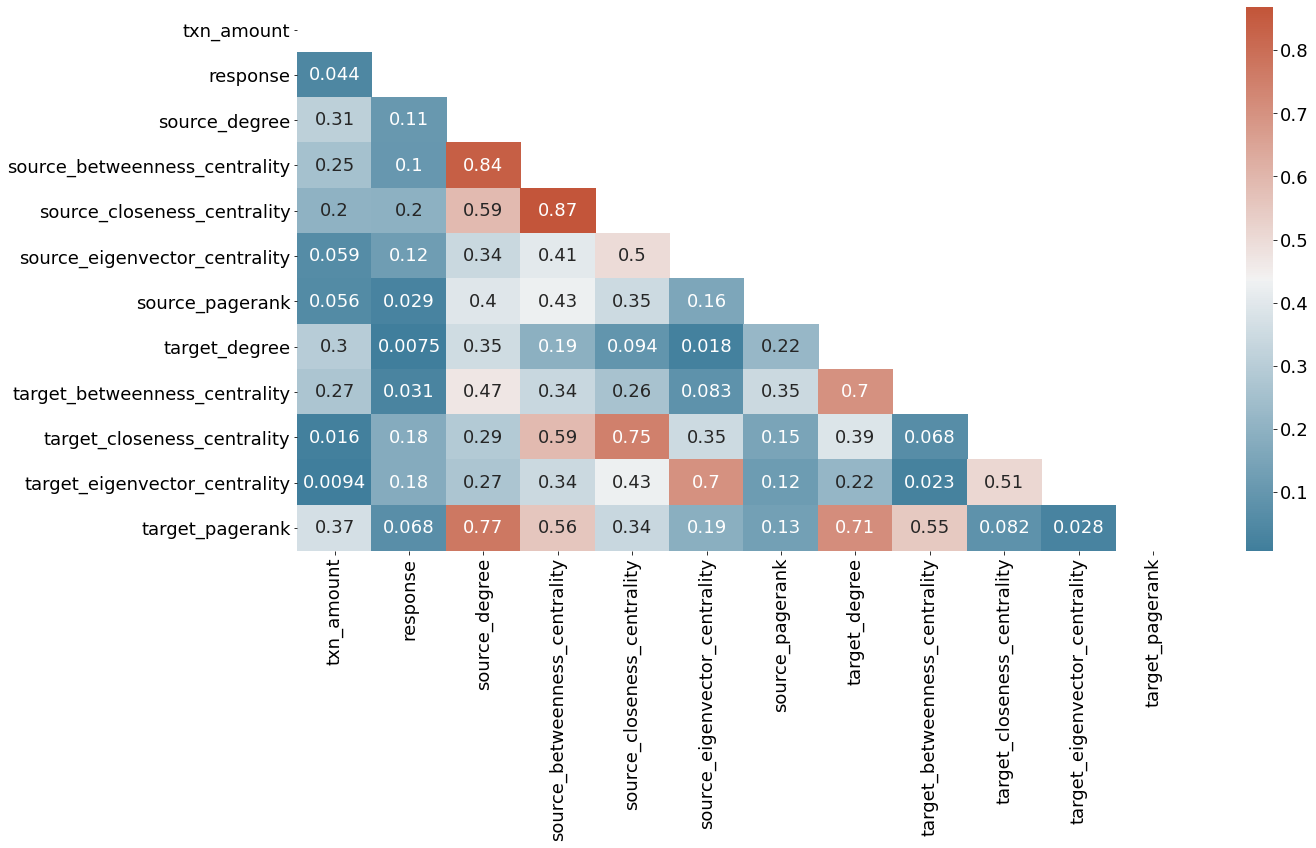

In [45]:
# plotting correlation 
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(lvl2_cen.corr()), dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(lvl2_cen.corr(method='spearman')),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );

In [46]:
# test for monotonic correlation with fraud
cen_corr = lvl2_cen.corr(method='spearman').abs()
cen_corr.loc[cen_corr['response']>=0.05,['response']].sort_values(by=['response'],ascending=False)

,response
response,1.000000
source_closeness_centrality,0.197089
target_closeness_centrality,0.177061
target_eigenvector_centrality,0.176907
source_eigenvector_centrality,0.121874
source_degree,0.106237
source_betweenness_centrality,0.103561
target_pagerank,0.068138


#### Separate fraud/not fraud network for comparison

#####  Only fraud

**Build graph**
<br> **define nodes/edges**

In [47]:
lvl2_fraud = lvl2_final[lvl2_final['response']==1]
lvl2_fraud

,tran_date,source_name,target_name,TargetBank,txn_amount,response
0,2021-03-29,personal savings,digipay,UBP,30000.0,1
12,2021-03-05,john ildefonso villanueva,jennifer iracta,UBP,73220.0,1
89,2021-02-22,jennelyn de guzman,jennifer iracta,UBP,3500.0,1
1573,2021-03-05,gizelle reyes,jennifer iracta,UBP,146000.0,1
1661,2021-03-04,john ildefonso villanueva,jennifer iracta,UBP,40000.0,1
...,...,...,...,...,...,...
207996,2021-03-04,madeleine denise verano,jhona,NonUBP,3900.0,1
207997,2021-03-04,madeleine denise verano,stevien,NonUBP,3900.0,1
207998,2021-03-04,madeleine denise verano,shayne,NonUBP,50000.0,1
208000,2021-03-04,madeleine denise verano,jaaron,NonUBP,14000.0,1


In [48]:
# define edges 
df_edges = lvl2_fraud[['source_name','target_name','txn_amount']]

# create network 
G_fraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**Network statistics**

In [49]:
N_fraud = G_fraud.order() # number of nodes 
L_fraud = G_fraud.size() # number of edges

avg_deg_fraud = float(L_fraud) / N_fraud 

print("Nodes: ", N_fraud)
print("Edges: ", L_fraud)
print("Average degree: ", avg_deg_fraud)


Nodes:  11008
Edges:  12490
Average degree:  1.1346293604651163


**in-degree/out-degree**

In [50]:
# In-degree and Out-degree
in_degrees_fraud = G_fraud.in_degree()  # dictionary node:degree
out_degrees_fraud = G_fraud.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees_fraud['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees_fraud['personal savings']) #txn out of personal savings


Transactions in personal savings: 1
Transactions out personal savings: 157


#####  Only not-fraud 

In [51]:
lvl2_nonfraud = lvl2_final[lvl2_final['response']==0]
lvl2_nonfraud

,tran_date,source_name,target_name,TargetBank,txn_amount,response
2389,2021-04-28,angelou manalang,danilo cayetano,UBP,1500.0,0
2410,2021-05-04,camille lazo aguilar,danilo cayetano,UBP,500.0,0
2479,2021-04-07,josephine busalpa,jasmin cristobal,UBP,23839.0,0
7660,2021-03-24,mariejane bentor,kimbriel calizon,UBP,5000.0,0
7754,2021-03-24,crestalyn m lagundino,kimbriel calizon,UBP,400.0,0
...,...,...,...,...,...,...
207919,2020-10-06,jennifer firat,donna rose sicat,NonUBP,100.0,0
207920,2020-10-06,jennifer firat,criselda balbaira,NonUBP,31000.0,0
207921,2020-10-06,jennifer firat,glenda hilario,NonUBP,6160.0,0
207922,2020-10-06,jennifer firat,yolanda pichay arganoza,NonUBP,5300.0,0


In [52]:
lvl2_nonfraud.shape

(1164, 6)

In [53]:
# define edges 
df_edges = lvl2_nonfraud[['source_name','target_name','txn_amount']]

# create network 
G_nonfraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**Network statistics**

In [54]:
N_nonfraud = G_nonfraud.order() # number of nodes 
L_nonfraud = G_nonfraud.size() # number of edges

avg_deg_nonfraud = float(L_nonfraud) / N_nonfraud 

print("Nodes: ", N_nonfraud)
print("Edges: ", L_nonfraud)
print("Average degree: ", avg_deg_nonfraud)


Nodes:  1100
Edges:  1023
Average degree:  0.93


**in-degree/out-degree**

In [55]:
# In-degree and Out-degree
in_degrees_nonfraud = G_nonfraud.in_degree()  # dictionary node:degree
out_degrees_nonfraud = G_nonfraud.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees_nonfraud['aeron paul alfaro']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees_nonfraud['aeron paul alfaro']) #txn out of personal savings


Transactions in personal savings: 4
Transactions out personal savings: 0


#### fraud/not fraud comparison

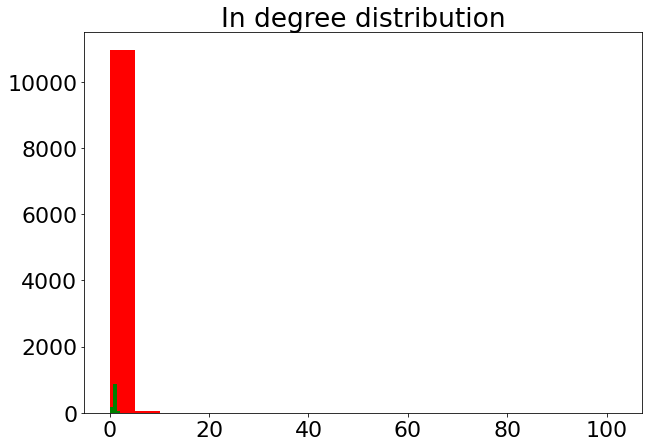

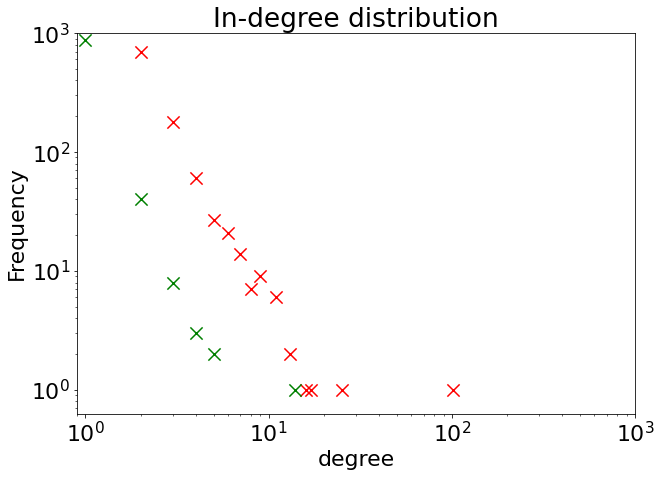

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


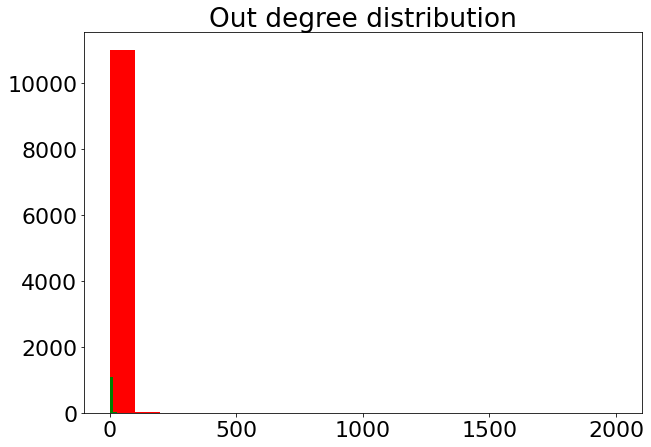

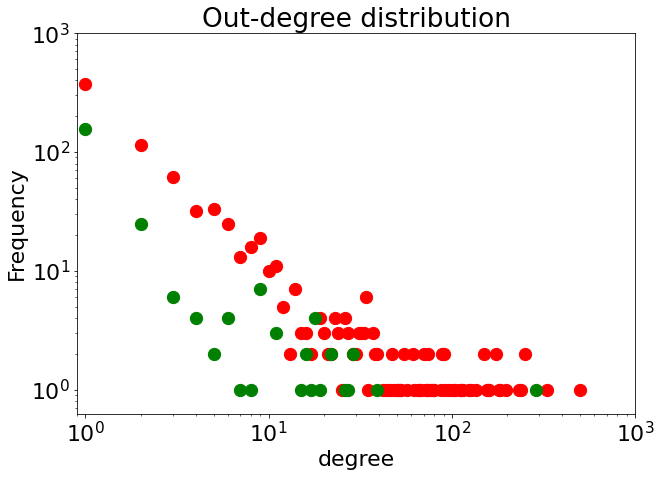

In [56]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(in_degrees_nonfraud()).values(), bins=20, density=False,color='green')
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_fraud_counts = dict(collections.Counter(dict(in_degrees_fraud()).values()))
in_degree_nonfraud_counts = dict(collections.Counter(dict(in_degrees_nonfraud()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_fraud_counts.keys(), in_degree_fraud_counts.values(), c='r', marker='x', s=150)
plt.scatter(in_degree_nonfraud_counts.keys(), in_degree_nonfraud_counts.values(), c='g', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data_nonfraud = np.array(list(in_degree_nonfraud_counts.values()),dtype=np.float32)
fit_nonfraud = powerlaw.Fit(data_nonfraud)
data_fraud = np.array(list(in_degree_fraud_counts.values()),dtype=np.float32)
fit_fraud = powerlaw.Fit(data_fraud)

#Histogram of out-degrees
plt.hist(dict(out_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(out_degrees_nonfraud()).values(), bins=20, density=False, color='green')
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_fraud_counts = dict(collections.Counter(dict(out_degrees_fraud()).values())) 
out_degree_nonfraud_counts = dict(collections.Counter(dict(out_degrees_nonfraud()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_fraud_counts.keys(), out_degree_fraud_counts.values(), c='r', marker='o', s=150)
plt.scatter(out_degree_nonfraud_counts.keys(), out_degree_nonfraud_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

#### Network visualisation

In [57]:
# define edges 
df_edges = lvl2_final[['source_name','target_name','txn_amount']]

# define nodes 
df_source = lvl2_final[['source_name','response']]
df_target = lvl2_final[['target_name','response']]

# node colours 
node_colours = {1 : 'red', 0 : 'green'}
df_source['node_colour'] = lvl2_final['response'].map(node_colours)
df_target['node_colour'] = lvl2_final['response'].map(node_colours)

source_attr = df_source.set_index('source_name').T.to_dict()
target_attr = df_target.set_index('target_name').T.to_dict()

source_fraud_colour = {k:v['node_colour'] for k, v in source_attr.items()}
target_fraud_colour = {k:v['node_colour'] for k, v in target_attr.items()}

fraud_colour_dict = {**source_fraud_colour, **target_fraud_colour}

# create network 
G = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**networkx**

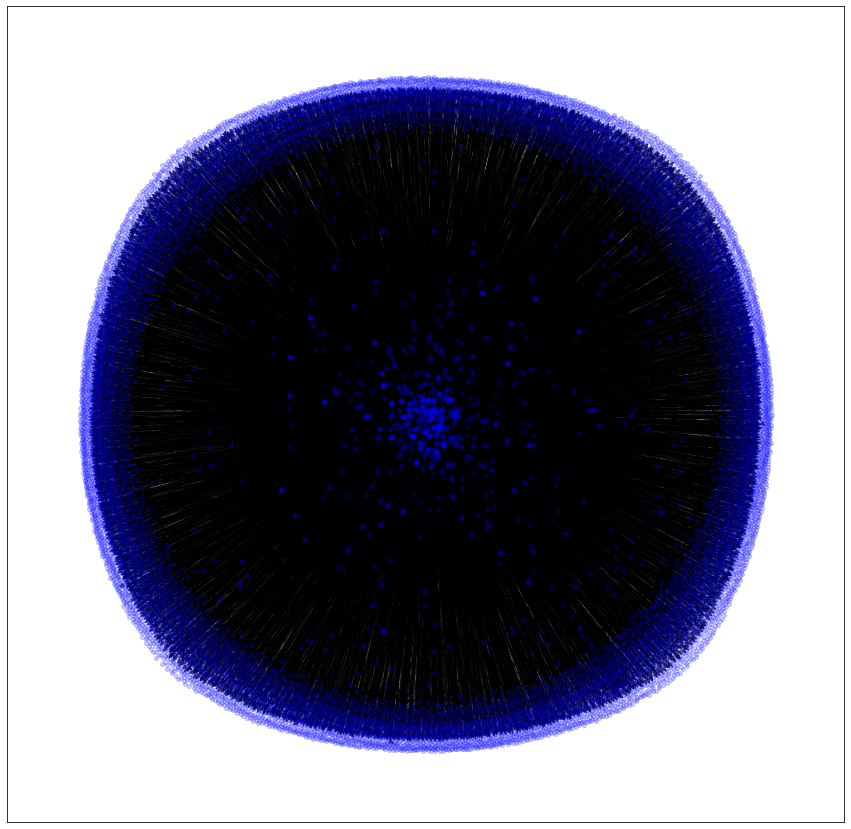

In [58]:
plt.figure(figsize=(15,15)) 

# create the layout
pos = nx.spring_layout(G)

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G,pos,node_color='b',alpha=0.2,node_size=16)
nx.draw_networkx_edges(G,pos,alpha=0.5);

plt.savefig('level2_basic.png',format='png') 
plt.show()

In [59]:
plt.figure(figsize=(15,15)) 
nx.draw_networkx(G, 
    pos = nx.spring_layout(G, weight = 'txn_amount'), # based on optimal distance between nodes 
    node_size = 50, 
    node_color = [fraud_colour_dict[n] for n in G.nodes()],
#     width = [G.edges[e]['txn_amount'] for e in G.edges],
    width = 0.2,
    with_labels = False)
plt.plot();

plt.savefig('level2_colornode.png',format='png') 
plt.show()

**plot based on betweenness**

In [60]:
plt.figure(figsize=(15,15))
betweennessCentrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_size =  [v * 10000 for v in betweennessCentrality.values()]

pos = nx.spring_layout(G)
nx.draw_networkx(G, 
                 pos=pos, 
                 with_labels=False,
                 node_color = [fraud_colour_dict[n] for n in G.nodes()],
                 node_size = node_size )

**bokeh**

In [61]:
# Use the spring layout to position the nodes
pos = nx.spring_layout(G, weight = 'txn_amount')

plot = figure(title='level 2', tools='', toolbar_location=None)

graph = from_networkx(G, pos, scale=10, center=(0,0))
plot.renderers.append(graph)

output_file("level_2.html")
show(plot)

**plot based on degree**

In [62]:
# define edge colours
not_fraud_colour, fraud_colour = 'green', 'red'
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_colour = not_fraud_colour if df_source[df_source['source_name']==start_node]['response'].iloc[0] == 0 else fraud_colour
    edge_attrs[(start_node, end_node)] = edge_colour

nx.set_edge_attributes(G, name='edge_colour', values=edge_attrs)

# set nodes
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

source_response = {k:v['response'] for k, v in source_attr.items()}
target_response = {k:v['response'] for k, v in target_attr.items()}
fraud_response = {**source_response, **target_response}
nx.set_node_attributes(G, name='fraud_response', values=fraud_response)

node_size = dict([(node, degree/10) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='node_size', values=node_size)
# node_colours = {1 : 'red', 0 : 'green'}
# 1 - red/green 
mapper = linear_cmap('fraud_response', palette=Spectral8, low=1, high=1, low_color='green', high_color='red')

# Show with Bokeh
plot = Plot(width=600, height=600,
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1))
plot.title.text = 'level 2'

node_hover_tool = HoverTool(tooltips=[('name', '@index'), ('degree', '@degree')])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), TapTool(),WheelZoomTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0, 0))

# graph_renderer.node_renderer.glyph = Circle(size=5, fill_color=Spectral4[0])
graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=mapper)

graph_renderer.edge_renderer.glyph = MultiLine(line_color='edge_colour', line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_file('level_2.html')
show(plot)

#### Modularity 
Community detection is a measure of network structure. It was designed to measure the strength of division of a network into modules. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.


Identify partitions within the network and then colour nodes based on which partition they lie in. 

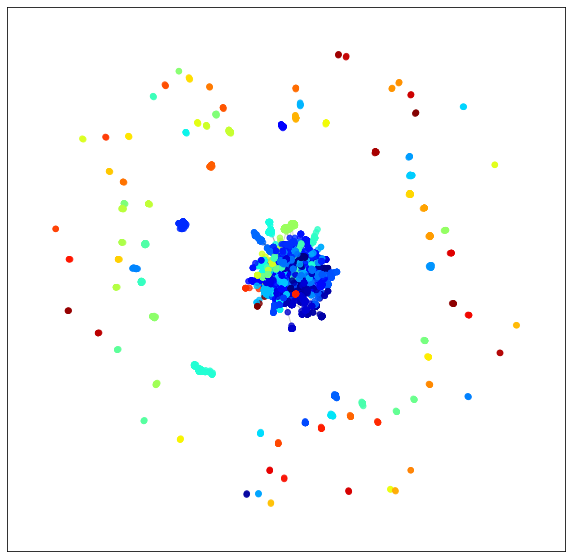

In [63]:
# Unfortunately, the network first has to be undirected.
G_ud = G.to_undirected() 
N = G_ud.order() # number of nodes

nx.transitivity(G_ud)

# find modularity
part = community.best_partition(G_ud)
mod = community.modularity(part, G_ud)

# plot, color nodes using community structure
values = [part.get(node) for node in G_ud.nodes()]
#k indicates separation strength, bigger=> further apart nodes
pos = nx.spring_layout(G_ud, iterations=100, k=100.0/N) 

plt.figure(figsize=(10,10)) 
nx.draw_networkx_nodes(G_ud,
                       pos,
                       cmap=plt.get_cmap('jet'),
                       node_color=values, 
                       node_size=30, 
                       label=None,
                       alpha=0.8)

nx.draw_networkx_edges(G_ud,
                       pos,
                       alpha=0.2)

plt.savefig('network_cluster_lvl2.png')
plt.show()


**export output to file**

In [64]:
nx.write_graphml(G,'fraud_network_lvl2.graphml') 
nx.write_gml(G,'fraud_network_lvl2.gml') 
nx.write_gexf(G, 'fraud_network_lvl2.gexf')


##### Modularity-Based Community Detection: The Louvain Method
The modularity quantifies how good a "community" or partition is, and is given by ___ where n is the number of communities,
L is the number of links within the community, k is the total degree of nodes belonging to the community, and L is the total number of links in the network. 

In [65]:
G_ud = G.to_undirected() 
partition = community.community_louvain.best_partition(G_ud)

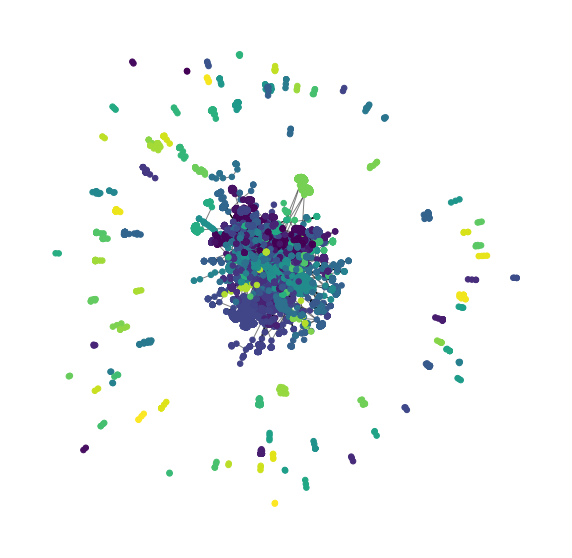

In [66]:
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(G_ud)
nx.draw_networkx_nodes(G_ud, pos, node_size=30, node_color=list(partition.values()))
nx.draw_networkx_edges(G_ud, pos, alpha=0.5)
# nx.draw_networkx_labels(G_ud, pos)
plt.show()


##### cliques
Cliques are complete subgraphs; that is, subgraphs are where the nodes are all directly connected to each other. A subgraph of a graph G having vertex set V and edge set E is a graph H having edge set contained in V and edge set contained in E. 
Note that any two connected nodes in an undirected network are considered to form a clique.

In [67]:
# Unfortunately, the network first has to be undirected.
G_ud = G.to_undirected() 

In [68]:
nx.graph_number_of_cliques(G_ud)

12582